# A Movie Analysis for Microsoft

**Author:** Benjamin Dean
***

## Project Overview

Students were given a scenario in which Microsoft has decided to begin their own movie studio and is looking for advice on how to do so. This project begins with exploratory data analysis and determines profit and ratings to be the target dependant variables. Data is then cleaned, merged, and modeled. Visualizations were made comparing different variables to the target variables. Finally, analysis suggests Microsoft take a number of actions in reference to genres, directors, and production budgets in order to build a successful movie portfolio.

### Business Problem

## Data Understanding

We first perform an exploratory data analysis on six dataframes imported from csv files supplied by websites IMDB.com, TheMovieDb.org, and the-numbers.com.

#### Import Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_rows', 100)

#### Import datasets

In [17]:
ratings = pd.read_csv('data/zippedData/imdb.title.ratings.csv.gz')
basics = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
directors = pd.read_csv('data/zippedData/imdb.title.crew.csv.gz')
names = pd.read_csv('data/zippedData/imdb.name.basics.csv.gz')
releases = pd.read_csv('data/zippedData/tmdb.movies.csv.gz')
budgets = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')

## Data Preparation

#### Remove unwanted columns and rows

In [18]:
ratings = ratings.drop(ratings[ratings.numvotes < 100].index)
names = names[names['primary_profession'].str.contains('director', na=False)]
names.drop(columns = ['birth_year', 'death_year', 'known_for_titles'], inplace=True)
basics.drop(columns = ['original_title', 'runtime_minutes'], inplace=True)
directors.drop(columns = 'writers', inplace=True)
releases.drop(columns = ['genre_ids', 'id', 'original_language', 'popularity',\
                         'original_title', 'vote_average', 'vote_count'], inplace=True)

#### Rename columns to allow for dataset merging

In [19]:
directors.rename(columns={'directors': 'nconst'}, inplace=True)
releases.rename(columns={'title': 'primary_title'}, inplace=True)
budgets.rename(columns={'movie': 'primary_title'}, inplace=True)

In [20]:
releases.release_date = pd.to_datetime(releases.release_date)
budgets.release_date = pd.to_datetime(budgets.release_date)

#### Merge datasets

In [21]:
genres_by_ratings = pd.merge(ratings, basics, on='tconst')\
                      .merge(directors, on='tconst')\
                      .merge(names, on='nconst')\
                      .merge(releases, on='primary_title' )\
                      .merge(budgets, on=['primary_title', 'release_date'])

#### Remove unwanted characters in order to make values convertable to integers

In [23]:
series_list = ['production_budget', 'domestic_gross', 'worldwide_gross']
for series in series_list:
    for symbol in ['$', ',']:
        genres_by_ratings[series] = genres_by_ratings[series].str.replace(symbol,'')
    genres_by_ratings[series] = pd.to_numeric(genres_by_ratings[series])

#### Add profit column

In [24]:
genres_by_ratings['profit'] = genres_by_ratings['worldwide_gross'] - genres_by_ratings['production_budget']

In [25]:
budgets.rename(columns={'movie': 'primary_title'}, inplace=True)

#### Here we group our data together by genres and evaluate only the groups containing 3 or more movies.
#### Genres are then sorted by their aggregated profit and prepared for graph.

In [26]:
genres_by_ratings = genres_by_ratings[genres_by_ratings.groupby('genres').genres.transform(len) >=3]
for_graph = genres_by_ratings.groupby('genres').mean()
for_graph = for_graph.loc[:,['production_budget', 'profit', 'worldwide_gross']]
for_graph.sort_values(by='profit', ascending=False, inplace=True)
for_graph = for_graph.head(10)
for_graph.head()

,production_budget,profit,worldwide_gross
genres,,,
"Adventure,Drama,Sci-Fi",1.270000e+08,5.319741e+08,6.589741e+08
"Action,Adventure,Sci-Fi",1.663886e+08,5.234292e+08,6.898177e+08
"Adventure,Fantasy",2.316667e+08,4.695440e+08,7.012107e+08
"Adventure,Family,Fantasy",1.606818e+08,3.744137e+08,5.350955e+08
"Action,Adventure,Comedy",1.102500e+08,3.537390e+08,4.639890e+08


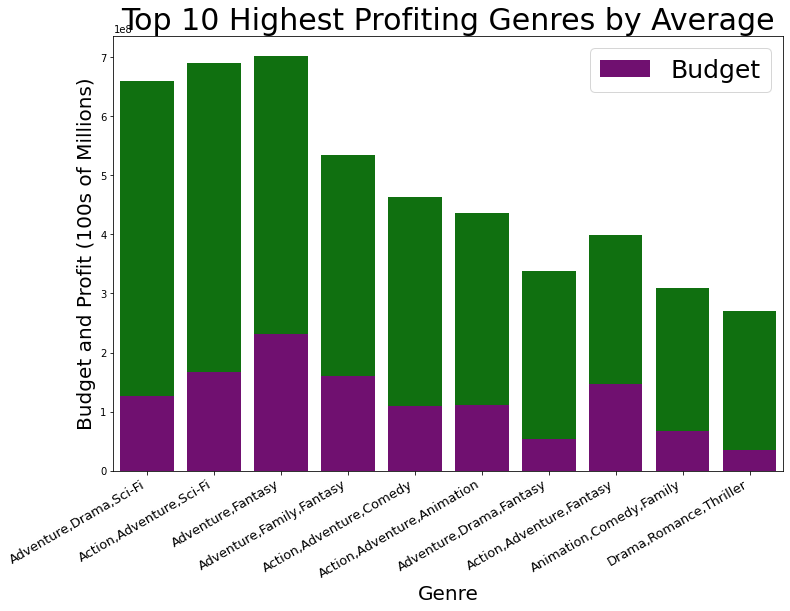

In [31]:
sns.set_context({'figure.figsize': (12,8)})
sns.barplot(x=for_graph.index, y=for_graph.worldwide_gross, color='green')
sns.barplot(x=for_graph.index, y=for_graph.production_budget, color='purple', label='Budget')
plt.title('Top 10 Highest Profiting Genres by Average', fontsize=30)
plt.xlabel('Genre', fontsize=20)
plt.ylabel("Budget and Profit (100s of Millions)", fontsize=20)
plt.xticks(rotation=30, ha='right', fontsize=13)
plt.legend(prop={'size': 25});

In [13]:
second_graph = genres_by_ratings.groupby('primary_name').mean()
second_graph = second_graph.loc[:, ['averagerating', 'profit']]
second_graph.sort_values(by='profit', ascending=False, inplace=True)
second_graph = second_graph.head(25)

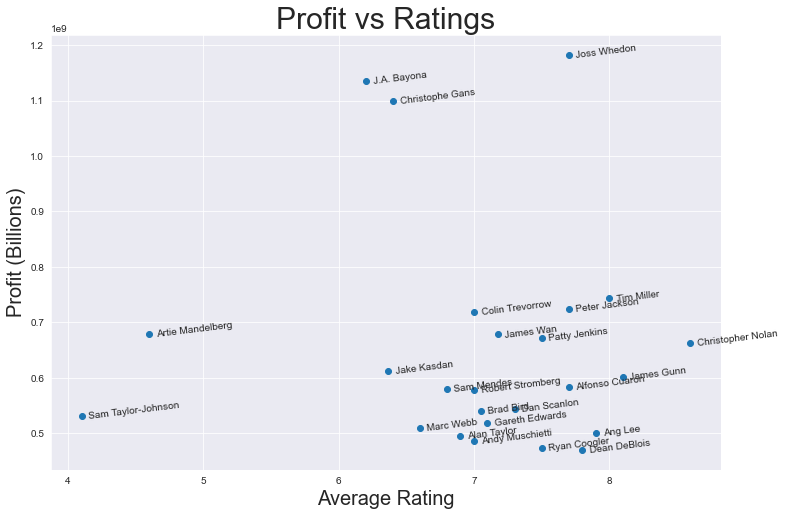

In [20]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
v = second_graph.averagerating
w = second_graph.profit
annotations = second_graph.index
plt.scatter(v,w)
plt.title('Profit vs Ratings', fontsize=30)
plt.xlabel('Average Rating', fontsize=20)
plt.ylabel('Profit (Billions)', fontsize=20)
for i, label in enumerate(annotations):
    plt.annotate(label, (v.iloc[i]+.05, w.iloc[i]-5000000), rotation=7)
plt.show();

#### Ratings by Expenditure

In [19]:
third_graph = genres_by_ratings.loc[:, ['averagerating', 'production_budget', 'profit']]
third_graph['budget_grp'] = None
for element in range(len(third_graph.budget_grp)):
    if third_graph.production_budget.iloc[element] <= 25000000:
        third_graph.budget_grp.iloc[element] = '<=25'
    elif third_graph.production_budget.iloc[element] > 25000000 and third_graph.production_budget.iloc[element] <= 50000000:
        third_graph.budget_grp.iloc[element] = '<=50'
    elif third_graph.production_budget.iloc[element] > 50000000 and third_graph.production_budget.iloc[element] <= 75000000:
        third_graph.budget_grp.iloc[element] = '<=75'
    elif third_graph.production_budget.iloc[element] > 75000000 and third_graph.production_budget.iloc[element] <= 100000000:
        third_graph.budget_grp.iloc[element] = '<=100'
    elif third_graph.production_budget.iloc[element] > 100000000 and third_graph.production_budget.iloc[element] <= 125000000:
        third_graph.budget_grp.iloc[element] = '<=125'
    elif third_graph.production_budget.iloc[element] > 125000000 and third_graph.production_budget.iloc[element] <= 150000000:
        third_graph.budget_grp.iloc[element] = '<=150'
    elif third_graph.production_budget.iloc[element] > 150000000 and third_graph.production_budget.iloc[element] <= 175000000:
        third_graph.budget_grp.iloc[element] = '<=175'
    elif third_graph.production_budget.iloc[element] > 175000000 and third_graph.production_budget.iloc[element] <= 200000000:
        third_graph.budget_grp.iloc[element] = '<=200'
    else:
        third_graph.budget_grp.iloc[element] = '>200'

C:\Users\benja\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [20]:
third_graph = third_graph.loc[:, ['averagerating', 'budget_grp']]

In [21]:
twntyfvmil = third_graph.loc[third_graph.budget_grp == '<=25']
twntyfvmil = twntyfvmil.averagerating
fftymil = third_graph.loc[third_graph.budget_grp == '<=50']
fftymil = fftymil.averagerating
svntyfvmil = third_graph.loc[third_graph.budget_grp == '<=75']
svntyfvmil = svntyfvmil.averagerating
hndmil = third_graph.loc[third_graph.budget_grp == '<=100']
hndmil = hndmil.averagerating
hndtwntyfvmil = third_graph.loc[third_graph.budget_grp == '<=125']
hndtwntyfvmil = hndtwntyfvmil.averagerating
hndfftymil = third_graph.loc[third_graph.budget_grp == '<=150']
hndfftymil = hndfftymil.averagerating
hndsvntyfvmil = third_graph.loc[third_graph.budget_grp == '<=175']
hndsvntyfvmil = hndsvntyfvmil.averagerating
twohndmil = third_graph.loc[third_graph.budget_grp == '<=200']
twohndmil = twohndmil.averagerating
grtrtwohndmil = third_graph.loc[third_graph.budget_grp == '>200']
grtrtwohndmil = grtrtwohndmil.averagerating

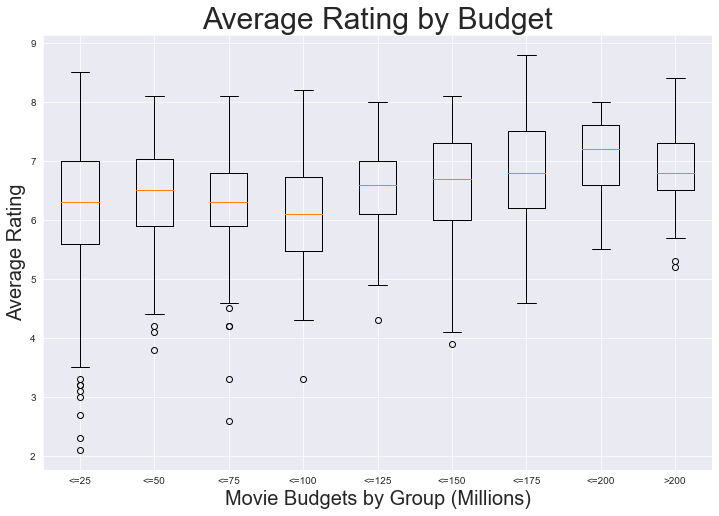

In [26]:
plt.boxplot([twntyfvmil, fftymil, svntyfvmil, hndmil, hndtwntyfvmil, hndfftymil, hndsvntyfvmil, twohndmil, grtrtwohndmil],\
           labels=['<=25', '<=50', '<=75', '<=100', '<=125', '<=150', '<=175', '<=200', '>200']);
plt.title('Average Rating by Budget', fontsize = 30)
plt.xlabel('Movie Budgets by Group (Millions)', fontsize = 20)
plt.ylabel('Average Rating', fontsize = 20);